In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2 

import tqdm

from nd2reader import ND2Reader
import h5py
import pickle

import datetime

import warnings
warnings.filterwarnings('ignore')

import ffmpeg

from skimage.filters import rank, threshold_otsu, threshold_local#

from skimage import morphology

import scipy 
import skimage

import pandas as pd
import seaborn as sns
import csv

c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
root_path = "E:/instru_projects/TimeLapses"

results = os.path.join(root_path, "results")
video_path = os.path.join(root_path, "240311_timelapses_3lines_spheroidseeded96h001.nd2")


In [3]:
#Incease birghtness if the video is dark (visualization)
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img


def load_metadata(images):
    meta_dict = {}
     # number of locations start 1
    meta_dict["n_fields"] = images.metadata['fields_of_view'].stop

    #number of timeseteps
    meta_dict["n_frames"] = images.metadata['num_frames']

    
    #meta_dict["z_level"] = (np.max(images.metadata['z_coordinates'])-np.min(images.metadata['z_coordinates']))

    meta_dict["z_level"] =  float(images.metadata["z_coordinates"][:images.metadata["z_levels"].stop][-1]-images.metadata["z_coordinates"][:images.metadata["z_levels"].stop][0])/float(images.metadata["z_levels"].stop)
    #number of levels starting from 1
    meta_dict["n_levels"] = images.metadata['z_levels'].stop
    meta_dict["z_step"] = meta_dict["z_level"] /meta_dict["n_levels"]

    #list of channels
    meta_dict["channels"] = images.metadata['channels']

    #number of channels
    meta_dict["n_channels"] = len(meta_dict["channels"])

    meta_dict["m"] = images.metadata['pixel_microns']
    meta_dict["height"] = images.metadata["height"]
    meta_dict["width"] = images.metadata["width"]

    return meta_dict

def process_frame(img, x_start, y_start):

    #x_start = (0,2304)
    #y_start = (2304,0)
    
    frame = img.copy()
    #img_sec = img.copy()


    frame = scipy.ndimage.gaussian_filter(frame, (5,5))
    frame = frame.astype(int)

    glob_thresh = threshold_otsu(frame)
    binary_local = frame > glob_thresh

    radius = 30   
    footprint = morphology.disk(radius)

    local_otsu = rank.otsu(frame.copy(), footprint)
    lo = frame >= local_otsu    
    l1 = np.zeros_like(lo)
    l1[binary_local] = lo[binary_local]

    # could/should be improved    
    closingCoef = 5
    whiteTopCoef = 5
    dilationCoedf = 5

    l1 = 1-l1
    e = skimage.morphology.closing(l1, skimage.morphology.disk(closingCoef))
    e2 = skimage.morphology.white_tophat(e,skimage.morphology.disk(whiteTopCoef))
    e2 = skimage.morphology.dilation(e2,skimage.morphology.disk(dilationCoedf))

    tmp = e.astype("int")-e2.astype("int")
    #l2 = morphology.erosion(l1,footprint)
    #l3 = morphology.closing(l2,footprint)

    tmp[tmp<0] = 0
    tmp = tmp.astype("uint8")

    # detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
    contours, hierarchy = cv2.findContours(image=tmp, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE) 

    # draw contours on the original image
    image_copy = np.zeros_like(frame.copy())

    prev = 0
    big_idx = 0

    for idx, i in enumerate(contours):

        current = cv2.contourArea(i)

        border = (np.sum(contours[idx] > y_start[0]-10) < 1 )*(np.sum(contours[idx] > y_start[1]-10) < 1 )*(np.sum(contours[idx] < x_start[0]+10) < 1 )*(np.sum(contours[idx] < x_start[1]+10) < 1)

        if (current > 4**2) & (current <1e6) & (prev < current) &  (border)  :
            big_idx = idx
            prev = current


    cv2.fillPoly(image_copy, pts = [contours[big_idx]], color=(2**16,0,0))
    cv2.drawContours(image=image_copy, contours=contours, contourIdx=big_idx, color=(2**16,0,0), thickness=3)

    (x_,y_),radius = cv2.minEnclosingCircle(contours[big_idx])
    area = cv2.contourArea(contours[big_idx])

    s_1 = int(x_-radius*2.5)
    if s_1<0:
        s_1 = 0

    e_1 = int(x_+radius*2.5)
    if e_1>2304:
        e_1=2304

    s_2 = int(y_+radius*2.5)
    if s_2 >2304:
        s_2 = 2304

    e_2 = int(y_-radius*2.5)
    if e_2 < 0:
        e_2 = 0


    start_pos = (s_1,e_2)
    end_pos = (e_1,s_2)

    #cv2.rectangle(img_sec, start_pos, end_pos, (2**16,0,0), 5)

    #plt.imshow(np.hstack([e, e2, tmp]))
    #plt.show()

    #plt.imshow(np.hstack([img_sec, image_copy]))
    #plt.show()


    return x_, y_, radius, area, start_pos, end_pos, image_copy

def pile_data(current, total_dict, round, color):

    name = "loc_{}_ch_{}".format(round, color)
    total_dict[name] = {}

    total_dict[name]["x"] = []
    total_dict[name]["y"] = []
    total_dict[name]["z"] = []
    total_dict[name]["r"] = []
    total_dict[name]["area"] = []
    total_dict[name]["mask"] = []

    for i in range(len(current)):
        total_dict[name]["x"].append(current[i][0])
        total_dict[name]["y"].append(current[i][1])
        total_dict[name]["r"].append(current[i][2])
        total_dict[name]["area"].append(current[i][3])
        total_dict[name]["z"].append(current[i][4])
        total_dict[name]["mask"].append(current[5])

    return total_dict


def mousePoints(event,x,y,flags,param):
    #Crop image
    global refPt
    global img_normalized
    global final_boundaries
    global stopper
    # Left button click
    if event == cv2.EVENT_LBUTTONDOWN:
        refPt = [(x, y)]
    elif event == cv2.EVENT_LBUTTONUP:
        refPt.append((x, y))
        final_boundaries.append((refPt[0],refPt[1]))
        stopper = True
        cv2.imshow("win", img_normalized)
        print("two clicks!")
    elif event == cv2.EVENT_MOUSEMOVE and flags == cv2.EVENT_FLAG_LBUTTON:
        clone = img_normalized.copy()
        cv2.rectangle(clone, refPt[0], (x, y), (0, 255, 0), 4)
        cv2.imshow("win", clone)


In [4]:

loc_id = 0
t_id = 0

channel = "BF"
final_boundaries = []
coords = []
stopper = False


with ND2Reader(video_path) as images:
    metas = load_metadata(images)
    #c -channel, v - locations, t - time
    images.iter_axes = "vt"
    images.bundle_axes = "zyx"

    for idx, img in enumerate(images):

        c_id = idx%metas["n_channels"]
        id_name = metas["channels"][c_id]

        if id_name != channel:
            continue

        if t_id == 0:
            cv2.namedWindow('win',cv2.WINDOW_NORMAL)
            cv2.setMouseCallback("win", mousePoints)
            for i in range(img.shape[0]):
                int_frame = (img[i]*2**8/(2**16)).astype("uint8")
                int_frame = np.stack((int_frame,int_frame,int_frame), axis = -1)
                img_normalized = cv2.normalize(int_frame, None, 0, 255, cv2.NORM_MINMAX)
                img_normalized = cv2.cvtColor(img_normalized, cv2.COLOR_BGR2RGB)

                cv2.imshow("win",img_normalized)
                k = cv2.waitKey(0) 
                        

                if stopper == True:
                    stopper = False
                    coords.append(final_boundaries)
                    final_boundaries = []
                    # Destroying present windows on screen
                    cv2.destroyAllWindows()
                    break     
            
        t_id += 1

        if t_id == metas["n_frames"]:
            t_id = 0
            loc_id += 1

cv2.destroyAllWindows()

two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!
two clicks!


In [5]:

with open(os.path.join(results, "init_coords.csv"), 'w') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    for i in range(len(coords)):
        write.writerow("{},{},{},{}".format(coords[i][0][0][0], coords[i][0][0][1], coords[i][0][1][0], coords[i][0][1][1]))

In [11]:
coords = []
with open(os.path.join(results, "init_coords.csv"), newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        row = row.split(",")
        coords.append([row[0],row[1],row[2],row[3]])

In [45]:

loc_id = 0
t_id = 0

out_name = os.path.join(results,'{}_{}_{}.mp4'.format(os.path.split(video_path)[1][:-4], (loc_id-1), datetime.date.today() ) )

out_process = ( 
ffmpeg 
.input('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'
.format(2304, 2304)) 
.output(out_name, pix_fmt='yuv420p') .overwrite_output() 
.run_async(pipe_stdin=True) 
)

channel = "BF"

track_list = []
total_dict = {}

with ND2Reader(video_path) as images:
    #c -channel, v - locations, t - time
    
    metas = load_metadata(images)
    images.iter_axes = "vt"
    images.bundle_axes = "zyx"


    vis_level = int(metas["n_levels"]/2)

    frames_tot = int((metas["n_channels"]*metas["n_fields"]*metas["n_frames"]))

    
    x_start = coords[loc_id][0][0] #(0,2304)
    y_start = coords[loc_id][0][1] #(2304,0) 


    for idx, img in tqdm.tqdm(enumerate(images),total=frames_tot):

        c_id = idx%metas["n_channels"]
        id_name = metas["channels"][c_id]


        if (id_name != channel) : #| (loc_id != 1)
            #t_id += 1
            #if t_id == metas["n_frames"]:
            #    t_id = 0
            #    loc_id += 1
            continue

        focus_level = 1e10
        focus_idx = 0

        x_final = x_start
        y_final = y_start

        for i in range(img.shape[0]):
    
            current_frame = img[i].copy()

            th = np.percentile(current_frame.flatten(),5)
            current_frame[current_frame>th] = 0
            

            x, y, r, area, x_start, y_start, mask = process_frame(current_frame, x_start, y_start)
            cropped = current_frame[x_start[1]:y_start[1], x_start[0]:y_start[0]]
            
            if (cropped.shape[0] == 0) or (cropped.shape[1] == 0):
                lap = np.inf
            else:
                lap = cv2.Laplacian(cropped, cv2.CV_64F).var()

            if focus_level > lap:

                focus_level = lap
                focus_idx = i

                x_final = x_start
                y_final = y_start
           
        x, y, r, area, x_start, y_start, mask = process_frame(img[focus_idx], x_final, y_final)

        int_frame = (img[focus_idx]*2**8/(2**16)).astype("uint8")
        int_frame = np.stack((int_frame,int_frame,int_frame), axis = -1)
        img_normalized = cv2.normalize(int_frame, None, 0, 255, cv2.NORM_MINMAX)
        img_normalized = cv2.cvtColor(img_normalized, cv2.COLOR_BGR2RGB)
        cv2.rectangle(img_normalized, x_start, y_start, (2**16,0,0), 5)

        #int_frame = increase_brightness(int_frame, 100)
        int_mask = (mask.astype(bool)*255).astype("uint8")
        int_mask = np.stack((int_mask,int_mask,int_mask), axis = -1)
        
        out_vis = cv2.addWeighted(img_normalized,1.0,int_mask,0.75,0)

        
        #cv2.imshow("win",cv2.resize(out_vis, (512,512)))
        #k = cv2.waitKey(0)
        #cv2.destroyAllWindows()

        if k == "q":
            break
        #plt.imshow(out_vis)
        #plt.show()

        out_process.stdin.write(out_vis)

        track_list.append([x*metas["m"], y*metas["m"], r*metas["m"], area*metas["m"]**2, (focus_idx-1)*metas["z_step"], mask])


         
        t_id += 1
        if t_id == metas["n_frames"]:
            total_dict = pile_data(track_list, total_dict, loc_id, channel)

            out_process.stdin.close()
            out_process.wait()

            t_id = 0
            loc_id += 1
            track_list = []
            if loc_id == metas["n_fields"]:
                break
            
            #if loc_id == 2:
            #    break

            x_start = coords[loc_id][0][0] #(0,2304)
            y_start = coords[loc_id][0][1] #(2304,0) 
            out_name = os.path.join(results,'{}_{}_{}.mp4'.format(os.path.split(video_path)[1][:-4], (loc_id-1), datetime.date.today() ) )
            out_process = ( 
            ffmpeg 
            .input('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'
            .format(2304, 2304)) 
            .output(out_name, pix_fmt='yuv420p') .overwrite_output() 
            .run_async(pipe_stdin=True) 
            )


with open(os.path.join(results,'{}_detections.pkl'.format(os.path.split(video_path)[1][:-4])), 'wb') as f:
    pickle.dump(total_dict, f)



 93%|█████████▎| 236/255 [5:57:10<28:45, 90.81s/it]   


OSError: [Errno 22] Invalid argument

In [34]:
out_name

'E:/instru_projects/TimeLapses\\results\\240311_timelapses_3lines_spheroidseeded96h001_0_2024-03-16.mp4'

In [338]:
sample_details = {
    "matrix": np.repeat("2mg/ml", 17),
    "cell": np.array(["MCF10A", "MCF10A", "MCF10A", "MCF10A", "MCF10A", "MCF10A", "MCF10A", "DCIS.COM", "DCIS.COM", "DCIS.COM", "DCIS.COM", "DCIS.COM", "DCIS.COM", "MCF10AT", "MCF10AT", "MCF10AT", "MCF10AT"]),
    "ignore": np.array([3, 4, 5, 6, 8, 10, 11, 12]),
    "stain": [],
    "dim": "3D",
    "incubation_time": "NA",
    "seeding_density": "NA",
    "passage_number": 0,
    "other": "NA"
}

In [378]:

for i, key in enumerate(total_dict):
    array_length = len(total_dict[key]["x"])
    total_dict[key]["label"] = np.repeat(sample_details["cell"][i], array_length)
    
    total_dict[key]["label"] = np.repeat(sample_details["cell"][i], array_length)
    total_dict[key]["location"] = np.repeat(i, array_length)
    total_dict[key]["time"] = np.arange(0,array_length)

    if i+1 in sample_details["ignore"]:
        total_dict[key]["ignore"] = np.repeat(True, array_length)
    else:
        total_dict[key]["ignore"] = np.repeat(False, array_length)

    if i == 0:
        d1 = total_dict[key]
    else:
        d1.update(total_dict[key])


df = pd.DataFrame()

for key in d1.keys():
    if key == "mask":
        continue
    df[key] = np.array(d1[key])

df_sub = df[df["ignore"] == False]


255
30
45
60
75
90
105
120
135
150
165
180
195
210
225
240
255


(16, 'MCF10AT')


Text(0, 0.5, 'Area (um^2)')

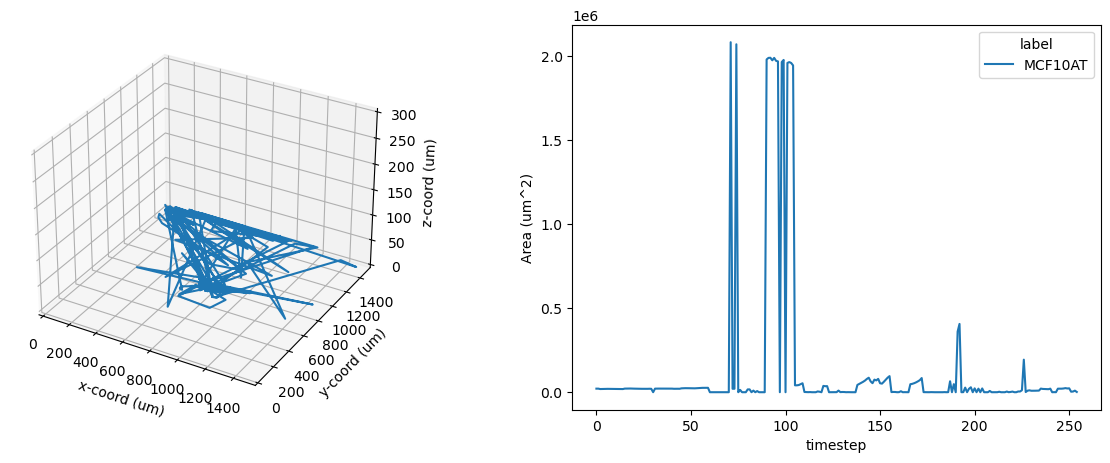

In [373]:
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2)

for tag, data in df_sub.groupby(["location", "label"]):
    ax1.plot3D(data["x"],  data["y"],data["z"], label = "{}".format(tag))

sns.lineplot(x = "time", y = "area", hue = "label",data = df_sub)
#ax1.legend()
ax1.set_xlabel("x-coord (um)")
ax1.set_ylabel("y-coord (um)")
ax1.set_zlabel("z-coord (um)")
ax1.set_xlim((0,2304*metas["m"]))
ax1.set_ylim((0,2304*metas["m"]))
ax1.set_zlim((0,300))


ax2.set_xlabel("timestep")
ax2.set_ylabel("Area (um^2)")

Text(0, 0.5, 'Area (um^2)')

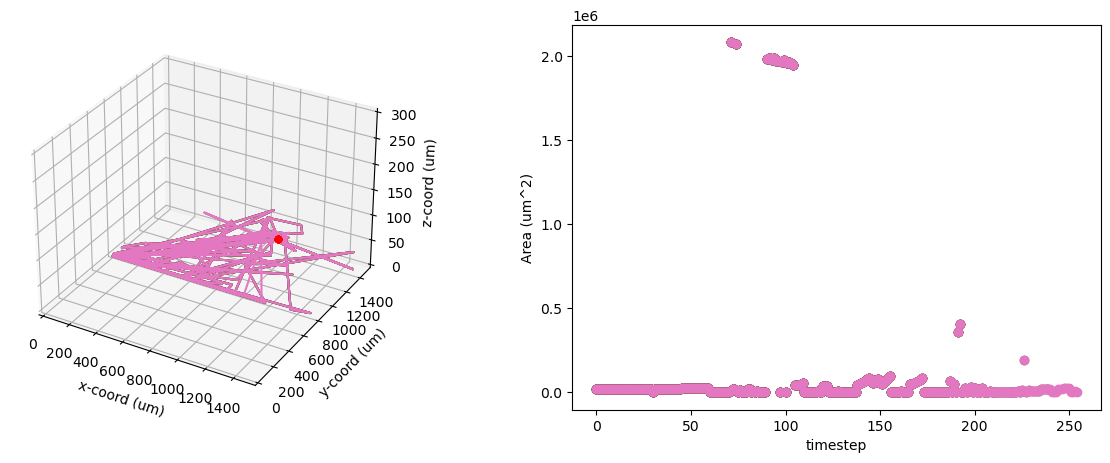

In [320]:
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2)

for i in total_dict.keys():
    ax1.scatter(np.array(total_dict[i]["x"])[0], 2304-np.array(total_dict[i]["y"])[0], color = "red", label = "start_{}".format(i))
    ax1.plot(np.array(total_dict[i]["x"]), 2304-np.array(total_dict[i]["y"]))

    ax2.scatter(np.arange(0,len(total_dict[i]["area"])),np.array( total_dict[i]["area"]))

#ax1.legend()
ax1.set_xlabel("x-coord (um)")
ax1.set_ylabel("y-coord (um)")
ax1.set_zlabel("z-coord (um)")
ax1.set_xlim((0,2304*metas["m"]))
ax1.set_ylim((0,2304*metas["m"]))
ax1.set_zlim((0,300))


ax2.set_xlabel("timestep")
ax2.set_ylabel("Area (um^2)")

In [321]:
pd.DataFrame.from_dict(total_dict, columns= total_dict.keys()[:-1])

TypeError: 'dict_keys' object is not subscriptable

In [322]:
len(total_dict)

17